<a href="https://colab.research.google.com/github/mucahidozcelik/NLP/blob/main/NLP_Bert_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [33]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


In [34]:
# set environment as googledrive to folder "resource"
data_path =  "/resource/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/resource/"

except:
    print("You are not working in Colab at the moment :(")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
df = pd.read_excel(data_path + "dataset(westerops).xlsx")

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  1490 non-null   object
 1   Label    1490 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [37]:
df.sample(10)

,comment,Label
887,Metodolojinin tasarımı projelerin genel yapısı...,ProjectManagement
220,Sonraki en iyi şey Evde çalışmanın önünde pek ...,HumanResource
1069,Bilançolar yatırımcılar için oldukça faydalıdı...,Muhasebe
536,Her bir projenin bir başlatıcısı ve sponsoru o...,ProjectManagement
496,Akademik yıl fakülte / sınıflandırılmamış akad...,HumanResource
808,Projenin bu safhası; üretim projeleri içinde i...,ProjectManagement
161,"Bir avukat planlayabilir, süreç için profesyon...",HumanResource
99,3. Değişimi ve belirsizliği kucaklayınGirişiml...,HumanResource
448,"Alternatif tanım : İnsan kaynakları, insanları...",HumanResource
515,"Raporda trendlerin görsel olarak gösterilmesi,...",ProjectManagement


In [38]:
df.head()

,comment,Label
0,Tüm bunların yanı sıra çalışanların ücretli iz...,HumanResource
1,Çalışanların hafta tatilleri ve resmi tatiller...,HumanResource
2,Ücretsiz izin çerçevesinde iş sözleşmesi askıy...,HumanResource
3,Memurlar hastalandıkları ve bu hastalıklarını ...,HumanResource
4,Bilindiği üzere 657 sayılı Kanunda devlet memu...,HumanResource


In [39]:
df.groupby('Label').size()

Label
HumanResource        511
Muhasebe             478
ProjectManagement    501
dtype: int64

Kategorik olan label'ları modelde kullanabilmemiz için kategori kolonunu encode etmemiz gerekiyor.

In [40]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['Label'])

In [42]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)

In [43]:
sentences = df.comment.values

In [44]:
max_len = 200

girdi uzunluğunu maksimum 200 olarak belirtiyoruz.

In [45]:
training = df.groupby('Label').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

burada elimizdeki metin verisini %80 ve %20 oranıyla, sırasıyla training ve test olarak ikiye bölüyoruz

In [46]:
print("Training: ", len(training))
print("Test: ", len(test))

Training:  1192
Test:  296


In [47]:
training_texts = training.comment.values
training_labels = training.encoded_categories.values

bu kısımda metin verisini modelde kullanmak üzere işliyoruz. öncelikle cümledeki kelimeler indirdiğimiz tokenizer ile tokenize ediliyor, sonrasında sınıflandırma probleminin çözülebilmesi için gerekli olan token'lar cümlenin sonuna ve başına ekleniyor. cümle maksimum uzunluktan kısaysa, input vektörümüz sabit uzunlukta olduğu için boşluklar dolduruluyor, uzunsa metin limit kadar kelime ile ifade ediliyor. attention mask'leri oluşturuluyor ve metinler işlemin sonucunda tensor objesi olarak geri dönüyor.

aşağıdaki çıktıda da görüldüğü üzere, metindeki kelimeler tokenizer'daki kelimelerin id'leri ile ifade ediliyor ve bu şekilde işleme sokuluyor.

In [51]:
input_ids = []
attention_masks = []

for comment in training_texts:
    if type(comment) == str: 
        encoded_dict = tokenizer.encode_plus(
                        comment ,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Örnek 2 - Tatil Talep Mektubu
Konu:  Tatil isteği [DATE] - [DATE]
Sayın [Yöneticinin Adı],
[TARİH - TARİH] için tatil talebinde bulunmak istiyorum. Ailemle tatil yapalı neredeyse 5 yıl oldu. Tatil saatlerimin bir kısmı çok ihtiyaç duyulan aile zamanı için kullanmak istiyorum. Şu anda 125 saatim var ve 40 tanesini kullanmak istiyorum.
Şu anda tüm çalışmalarım tamamlandı. Bu yolculuk için ayrılmadan önce, bekleyen tüm işlerin önceden tamamlanacağından da emin olacağım. Benim yokluğumda benim yerimi dolduranın, yapacak çok şeyi olmayacağından emin olacağım.
Bildiğiniz gibi, çalışkan biriyim ve haftada 60 saatten fazla çalışıyorum. Tazelenmenin ve tükenmemenin iyi bir yolu, arada bir tatil yapmaktır.
Uzun zamandır gecikmiş olduğumu hissediyorum. Şirket talepleri için birkaç kez geziyi beklemeye aldım. Ailemle geçirmek için biraz zamanım olsun istiyorum.
Resmi şirket Tatil Talep Formunu doldurdum ve inceleniz için ekledim. Seyahatimi planlayabilmem için lütfen bana yazılı olarak 

In [52]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

oluşturduğumuz tensor verisini modele vermek üzere dataloader değişkenine dönüştürüyoruz.

In [53]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

In [54]:
number_of_categories = len(df['encoded_categories'].unique())

In [56]:
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Downloading:   0%|          | 0.00/706M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

training'den önceki son adımda, toplam training adım sayısını ve kaç kere training yapılacağı sayısını belirliyoruz. bu sayıların yanında, öğrenmenin daha verimli olabilmesi ve learning rate optimizasyonu için bir scheduler yaratılıyor ve optimizer olarak Adam Optimizer kullanılıyoruz.

In [57]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [58]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

training aşamasına geçmeden önce seed değerini sabit bir değere eşitliyoruz ki, bütün deneylerimizde aynı sonucu alabilmek için .

training, toplam bölüm (epoch) sayısı kadar, bizde 4, kez yapılıyor. yukarıda training verisetini dataloader'a aktarmıştık, girdileri 32'şer 32'şer alıp modeli besliyoruz ve training başlıyor. her bölüm başlamadan önce optimize edilecek loss değeri sıfırlanıyor. modelin train() metotu çağırılıyor. çünkü test kısmında eval() metotu çağırılıyor. modelin katmanları train ve eval metotlarında farklı olarak davranıyor. dataloader'daki değerler GPU'ya aktarılıyor, gradient değerleri sıfırlanıyor ve output (logit) değerleri oluşuyor ve buna bağlı olarak loss değeri hesaplanıyor. backpropogation ile gradient'ler tekrar hesaplanıyor ve son olarak da learnig rate'le beraber parametreler de optimize ediliyor. her bölümün sonunda ortalama loss'u inceleyebiliriz.

In [60]:
seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Batch    10  of     38.    Elapsed: 0:00:11.
Batch    20  of     38.    Elapsed: 0:00:22.
Batch    30  of     38.    Elapsed: 0:00:33.
Average training loss: 0.50
Training epoch took: 0:00:41
======== Epoch 2 / 4 ========
Batch    10  of     38.    Elapsed: 0:00:11.
Batch    20  of     38.    Elapsed: 0:00:23.
Batch    30  of     38.    Elapsed: 0:00:35.
Average training loss: 0.07
Training epoch took: 0:00:43
======== Epoch 3 / 4 ========
Batch    10  of     38.    Elapsed: 0:00:11.
Batch    20  of     38.    Elapsed: 0:00:23.
Batch    30  of     38.    Elapsed: 0:00:34.
Average training loss: 0.02
Training epoch took: 0:00:42
======== Epoch 4 / 4 ========
Batch    10  of     38.    Elapsed: 0:00:11.
Batch    20  of     38.    Elapsed: 0:00:23.
Batch    30  of     38.    Elapsed: 0:00:34.
Average training loss: 0.00
Training epoch took: 0:00:43
Training completed in 0:02:49 (h:mm:ss)


training'deki model performansı incelemek için loss'daki düşüşü inceliyoruz.

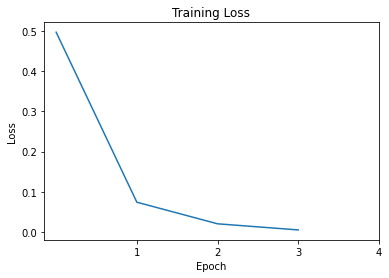

In [61]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

training verisetinde olduğu gibi, test veriseti için de bir dataloader oluşturuyoruz.

In [63]:
test_texts = test.comment.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


test verisini kullanarak modele sonuçları tahmin ettiriyoruz. batch değerimiz 32 olduğu için, model training'de olduğu gibi prediction kısmında da 32'şer 32'şer input'ları modele veriyor. o yüzden flatten fonksiyonu ile bütün sonuçları tek bir listede topluyoruz ve prediction_set değişkeninde saklıyoruz.

In [64]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [65]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

bu bir sınıflandırma problemi olduğu için performans metriklerinden F-score'u kullanmak istedim. bu kısımda Precision, Recall ve F-score değerlerini çıkartıyoruz, modelin performansını gözlemliyoruz.

In [66]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

görüldüğü üzere, kısıtlı bir veriseti ile bile iyi bir performans edilebiliyor. verisetinin kısıtlı olmasının dışında, cümlelerde 250'den fazla kelime olmasına rağmen, input layer kısmında her cümle 250 kelimeyle ifade edilip yüksek F-score elde edilebildi.

In [67]:
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

F-Score:  0.9595919236149122
Recall:  0.9594302588153552
Precision:  0.959973973710805


In [68]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

In [69]:
report = report.rename(columns={'0':'HumanResource',
                          '1':'Muhasebe',
                          '2':'ProjectManagement',
                          })

In [70]:
report

,HumanResource,Muhasebe,ProjectManagement,accuracy,macro avg,weighted avg
precision,0.979798,0.968085,0.932039,0.959459,0.959974,0.959904
recall,0.960396,0.957895,0.960000,0.959459,0.959430,0.959459
f1-score,0.970000,0.962963,0.945813,0.959459,0.959592,0.959570
support,101.000000,95.000000,100.000000,0.959459,296.000000,296.000000
